**Import dependencies**

In [ ]:
#!pip install git+https://github.com/ncullen93/torchsample

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-ame2lkw7
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-ame2lkw7
  Created wheel for torchsample: filename=torchsample-0.1.3-cp36-none-any.whl size=43417 sha256=0335c954fe49b8b66f6bd33b935eaca6805017200ce74affec726ab6eadd5822
  Stored in directory: /tmp/pip-ephem-wheel-cache-a15xxkum/wheels/88/c7/72/14cd9a173eed1e29d0b17d866e7d9ee511d31a834aedd27489
Successfully built torchsample


In [ ]:
import os
import fastprogress
import time

#import torchsample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
from sklearn.model_selection import TimeSeriesSplit


**Import Dataset**



In [ ]:
## UPLOAD CSV-FILE HERE ##
from google.colab import files
uploaded = files.upload()

Saving data_by_week.csv to data_by_week.csv


In [ ]:
data = pd.read_csv('data_by_week.csv',sep = ";")

**Getting to know the data**

In [ ]:
display(data.head())
display(data.shape)

,Woche,TS,TK,OG,FD,FF
0,02.01.12,461700,102878,187887,312672,24474
1,09.01.12,496850,125586,256039,398764,24214
2,16.01.12,566221,153878,247588,435166,22318
3,23.01.12,558765,131291,222069,411530,22743
4,30.01.12,607327,136636,271674,418642,26039


(417, 6)

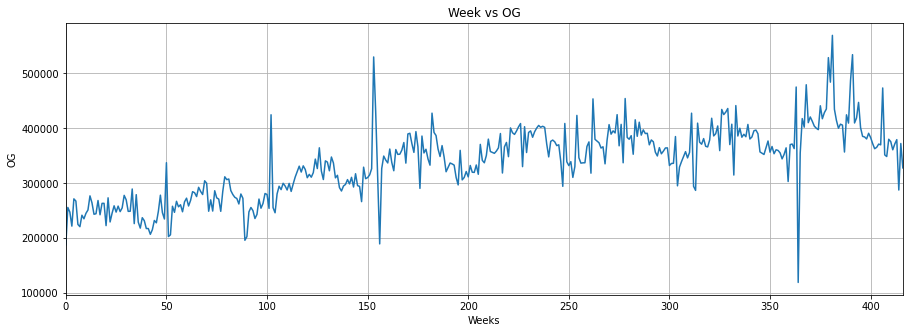

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Week vs OG')
plt.ylabel('OG')
plt.xlabel('Weeks')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['OG'])


**Data Preprocessing**

First change type of consumption goods to float


In [ ]:
all_data = data['OG'].values.astype(float)

Divide data into train-, vaildation- and testset

In [ ]:
test_data_size = 52
test_data = all_data[-test_data_size:]
train_data = all_data[:-test_data_size]

#test_data_size = 52
#test_data = all_data[-test_data_size:]

#all_train_data = all_data[:-test_data_size]

#val_data_size = 104
#val_data = all_train_data[-val_data_size:]
#train_data = all_train_data[:-val_data_size]


display(len(train_data))
#display(len(val_data))
display(len(test_data))


365

52

Normalize data and convert into tensors

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
#val_data_normalized = scaler.fit_transform(val_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
#val_data_normalized = torch.FloatTensor(val_data_normalized).view(-1)


In [ ]:
print(train_data_normalized[:5])
#print(val_data_normalized[:5])
#print(len(val_data_normalized))

tensor([-0.6670, -0.3349, -0.3761, -0.5004, -0.2587])
52


In [ ]:
train_window = 16

Adjust time series such that we can feed the data to the LSTM-model

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
#val_inout_seq = create_inout_sequences(val_data_normalized, train_window)
print(train_inout_seq[:5])
display(len(train_inout_seq))

[(tensor([-0.6670, -0.3349, -0.3761, -0.5004, -0.2587, -0.2780, -0.4854, -0.5053,
        -0.4037, -0.4354, -0.3871, -0.3573, -0.2321, -0.2941, -0.3952, -0.3904]), tensor([-0.2732])), (tensor([-0.3349, -0.3761, -0.5004, -0.2587, -0.2780, -0.4854, -0.5053, -0.4037,
        -0.4354, -0.3871, -0.3573, -0.2321, -0.2941, -0.3952, -0.3904, -0.2732]), tensor([-0.3997])), (tensor([-0.3761, -0.5004, -0.2587, -0.2780, -0.4854, -0.5053, -0.4037, -0.4354,
        -0.3871, -0.3573, -0.2321, -0.2941, -0.3952, -0.3904, -0.2732, -0.3997]), tensor([-0.2984])), (tensor([-0.5004, -0.2587, -0.2780, -0.4854, -0.5053, -0.4037, -0.4354, -0.3871,
        -0.3573, -0.2321, -0.2941, -0.3952, -0.3904, -0.2732, -0.3997, -0.2984]), tensor([-0.2982])), (tensor([-0.2587, -0.2780, -0.4854, -0.5053, -0.4037, -0.4354, -0.3871, -0.3573,
        -0.2321, -0.2941, -0.3952, -0.3904, -0.2732, -0.3997, -0.2984, -0.2982]), tensor([-0.4960]))]


349

In [ ]:
#print(val_inout_seq[:5])
#display(len(val_inout_seq))

[(tensor([ 0.1182,  0.8785,  0.4648,  0.4468,  0.4294,  0.3756,  0.3884,  0.2137,
         0.4545,  0.6153,  0.5176,  0.5512,  0.5300,  0.7171,  0.3982,  0.6177,
         0.2246,  0.8822,  0.4840,  0.4657,  0.5022,  0.3119,  0.6646,  0.4956,
         0.6400,  0.5077,  0.5616,  0.5240,  0.5266,  0.4084,  0.4582,  0.4397,
         0.3332,  0.2944,  0.3796,  0.3167,  0.3438,  0.3762,  0.3771,  0.1968,
         0.2177,  0.2192,  0.4931, -0.0112,  0.1804,  0.2365,  0.2883,  0.3386,
         0.2746,  0.3312,  0.7323, -0.0164]), tensor([-0.0577])), (tensor([ 0.8785,  0.4648,  0.4468,  0.4294,  0.3756,  0.3884,  0.2137,  0.4545,
         0.6153,  0.5176,  0.5512,  0.5300,  0.7171,  0.3982,  0.6177,  0.2246,
         0.8822,  0.4840,  0.4657,  0.5022,  0.3119,  0.6646,  0.4956,  0.6400,
         0.5077,  0.5616,  0.5240,  0.5266,  0.4084,  0.4582,  0.4397,  0.3332,
         0.2944,  0.3796,  0.3167,  0.3438,  0.3762,  0.3771,  0.1968,  0.2177,
         0.2192,  0.4931, -0.0112,  0.1804,  0.2365

52

**Creating LSTM model**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]



**Function to train the model**

In [ ]:
def train (inout_seq, optimizer,model,loss_fn, master_bar ):

    epoch_loss = []
  
    for seq, labels in fastprogress.progress_bar(inout_seq, parent=master_bar):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_fn(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss.append(single_loss.item())

    return np.mean(epoch_loss)

**Function to validate the model**

In [ ]:
def validate(inout_seq, model, loss_fn,master_bar):
    """Compute loss on validation set."""

  
    epoch_loss = []   

    model.eval()
    with torch.no_grad():
        for seq, labels in fastprogress.progress_bar(inout_seq, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(seq)
            
            # Compute loss
            single_loss = loss_fn(y_pred, labels)
            
            # For plotting the train loss, save it for each sample
            epoch_loss.append(single_loss.item())

            
    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss)


**Function to run training**

In [ ]:
def run_training(model, optimizer, loss_fn, num_epochs, 
                train_data, val_data, patience = 1,verbose=True, early_stopper = True):
    """ Run model training """
    
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses = [],[]


    for epoch in master_bar:
        # Train the model
        epoch_train_loss = train(train_data, optimizer, model,loss_fn, master_bar)
        # Validate the model
        epoch_val_loss = validate(val_data, model, loss_fn, master_bar)
        # Save loss for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.3f}, val loss: {epoch_val_loss:.3f}')
        
        if early_stopper:
           
           early_stopper.update(epoch_val_loss, model)
           if early_stopper.early_stop:
             model = early_stopper.load_checkpoint(model)
             break
         
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses


**Function to plot learning curves**

In [ ]:
def plot(title, label, train_results, val_results, yscale='linear', extra_pt=None, extra_pt_label = None):
    
    """Plot learning curves"""
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
        
    if extra_pt:
        plt.plot(extra_pt[0],extra_pt[1],marker = '*', color = 'k')
        plt.annotate(extra_pt_label,extra_pt)

    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)

    plt.show()

**Early Stopping**

In [ ]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=3):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accyracy does not increase, stop training early. 
                Defaults to 1.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.__early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        
        
    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        ####################

        if self.patience == self.counter:
          return True
        else:
          return(False)

        ####################

        
        
    def update(self, val_loss, model):
        """Call after one epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        ####################
        if val_loss < self.val_loss_min:
          self.save_checkpoint(model,val_loss)
          self.counter = 0
        else:
          self.counter = self.counter + 1
        return
        ####################


            
    def save_checkpoint(self, model, val_loss):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ...')
        ####################

        self.val_loss_min = val_loss
        torch.save({
                  'model_state_dict': model.state_dict(),
                   }, self.path)
        return
        ####################

 
        
    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        if self.verbose:
            print(f'Loading model from last checkpoint with validation loss {self.val_loss_min:.4f}')
        ####################

        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])

        
        return model

Finished training after 62 seconds.


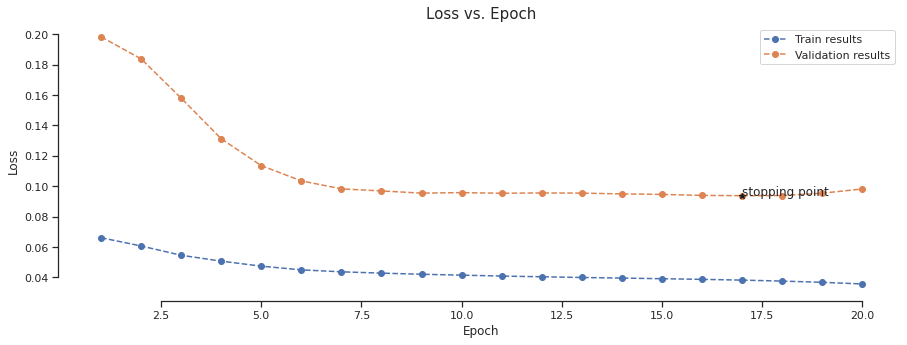

In [ ]:
# Training the model

model = LSTM( input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 100
stopper = EarlyStopper(patience = 3)

train_losses, val_losses = run_training(model, optimizer, loss_function, num_epochs, 
                train_inout_seq, val_inout_seq,verbose=True, early_stopper = stopper)

stop_point_loss = stopper.val_loss_min
stop_values = (val_losses.index(stop_point_loss)+1, stop_point_loss)
stop_values

plot("Loss vs. Epoch", "Loss", train_losses, val_losses, extra_pt = stop_values,
   extra_pt_label = 'stopping point',yscale='linear')


In [ ]:
fut_pred = 52

test_inputs = val_data_normalized[-train_window:].tolist()


In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())


In [ ]:
test_inputs[fut_pred:]

[-0.4482276439666748,
 -0.014344420284032822,
 -0.0017931722104549408,
 -0.023322694003582,
 -0.051324859261512756,
 -0.06222984939813614,
 -0.056504376232624054,
 -0.044966235756874084,
 -0.03516552597284317,
 -0.028619006276130676,
 -0.02404101938009262,
 -0.020118914544582367,
 -0.016375817358493805,
 -0.012900225818157196,
 -0.00988074392080307,
 -0.007382102310657501,
 -0.005350284278392792,
 -0.003691837191581726,
 -0.0023276060819625854,
 -0.0012043006718158722,
 -0.00028499774634838104,
 0.0004610121250152588,
 0.0010623503476381302,
 0.001545211300253868,
 0.0019321423023939133,
 0.0022416338324546814,
 0.0024886131286621094,
 0.0026851538568735123,
 0.0028411243110895157,
 0.002964586019515991,
 0.003062119707465172,
 0.003139019012451172,
 0.003199540078639984,
 0.0032470766454935074,
 0.0032843612134456635,
 0.003313535824418068,
 0.003336334601044655,
 0.0033541209995746613,
 0.0033679846674203873,
 0.003378773108124733,
 0.0033871550112962723,
 0.003393653780221939,
 0.00

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[217684.81636608]
 [294845.52415774]
 [297077.60673702]
 [293248.85040514]
 [288269.01534108]
 [286329.69915766]
 [287347.90299173]
 [289399.81704859]
 [291142.7507748 ]
 [292306.96747137]
 [293121.10521599]
 [293818.60253468]
 [294484.26558051]
 [295102.35609106]
 [295639.33320298]
 [296083.68538033]
 [296445.01881964]
 [296739.95290344]
 [296982.5643534 ]
 [297182.33017928]
 [297345.81671328]
 [297478.48524378]
 [297585.42572995]
 [297671.29651461]
 [297740.1073567 ]
 [297795.14655668]
 [297839.06873727]
 [297874.02104902]
 [297901.75844467]
 [297923.71456625]
 [297941.05971348]
 [297954.73529363]
 [297965.49820874]
 [297973.95199294]
 [297980.5825873 ]
 [297985.77092717]
 [297989.82540461]
 [297992.98849326]
 [297995.45397329]
 [297997.37256262]
 [297998.86317932]
 [298000.01890414]
 [298000.91526165]
 [298001.60790155]
 [298002.14286732]
 [298002.55593377]
 [298002.8745945 ]
 [298003.11938689]
 [298003.30786709]
 [298003.45196004]
 [298003.56259692]
 [298003.64607146]]


In [ ]:
x = np.arange(366, 418, 1)
print(x)


[366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417]


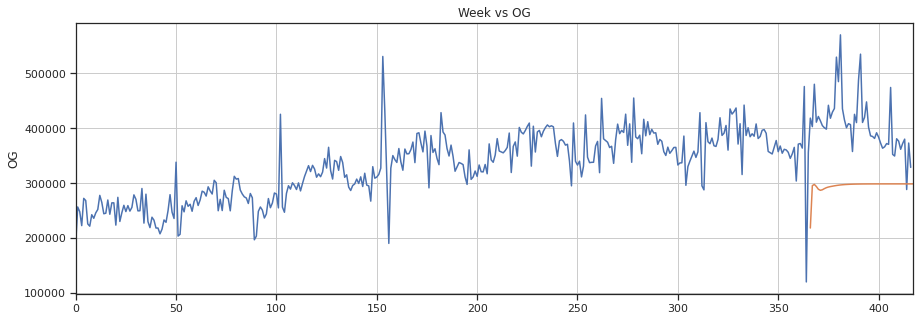

In [ ]:
plt.title('Week vs OG')
plt.ylabel('OG')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['OG'])
plt.plot(x,actual_predictions)
plt.show()


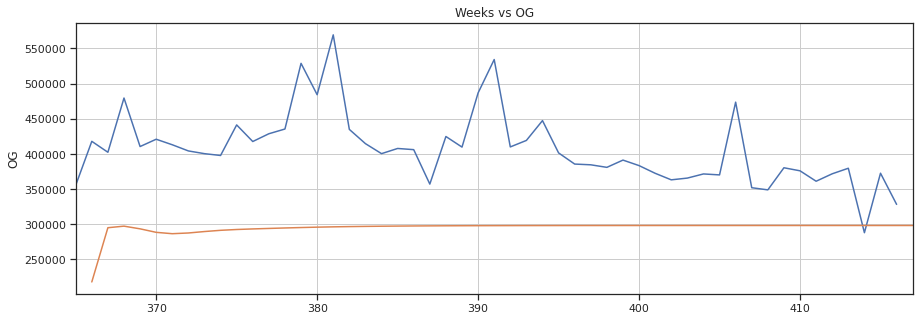

In [ ]:
plt.title('Weeks vs OG')
plt.ylabel('OG')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['OG'][-52:417])
plt.plot(x,actual_predictions)
plt.show()